# Определение перспективного тарифа для телеком компании

#### Описание проекта
«Мегалайн» — федеральный оператор сотовой связи.
Клиентам предлагают два тарифных плана: <b>«Смарт» и «Ультра»</b>. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

#### Описание тарифов
##### Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей
     
##### Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей
    
«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.



## Описание данных
#### Таблица users (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

#### Таблица calls (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

#### Таблица messages (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

#### Таблица internet (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

#### Таблица tariffs (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)



# Откроем файлы с данными и изучим общую информацию

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

In [3]:
def info(df):
    print('Содержимое таблицы (первые 5 строк): ' )
    print(df.head())
    print('-' * 100)
    
    print('Общая информация о таблице:')
    print(df.info())
    print('-' * 100)
      
    print('Количество дубликатов:', df.duplicated().sum())

    return

### Таблица `df['income'].loc[df['city'] != 'москва'].mean().round(2)`

In [4]:
info(df_users)

Содержимое таблицы (первые 5 строк): 
   user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
3     1003   23        NaN       Москва      Белла   Белякова  2018-08-17   
4     1004   68        NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14   

  tariff  
0  ultra  
1  smart  
2  smart  
3  ultra  
4  ultra  
----------------------------------------------------------------------------------------------------
Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object

Пропущенные значения только в колонке `churn_date`, связано это с тем, что абонент продолжает пользоваться тарифом.

In [5]:
for column in ['churn_date', 'reg_date']:
    df_users[column] = pd.to_datetime(df_users[column])

for column in ['city', 'first_name', 'last_name', 'tariff']:
    df_users[column] = df_users[column].str.lower()
    df_users[column]

Проверим, действительно ли каждое значение `user_id` встречается единственное число раз. Например, нет такого, что пользователь перешел с тарифа на тариф.

In [6]:
df_users.groupby('user_id')['user_id'].count().max()

1

Хорошо, что каждое значение `user_id` встречает только один раз.

Посмотрим, существует ли какая-то общая особенность у тех пользователей, кто закрыл свой тариф.

In [7]:
# добавим столбец 'delta_date' - количество дней пользования тарифом
df_users['delta_date'] = df_users['churn_date'] - df_users['reg_date']

In [8]:
df_users.query('churn_date.notnull()')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,delta_date
19,1019,63,2018-10-05,томск,игнатий,круглов,2018-05-16,ultra,142 days
20,1020,59,2018-12-18,чита,тала,костина,2018-10-22,smart,57 days
34,1034,66,2018-11-21,вологда,святослав,бондарев,2018-08-26,smart,87 days
50,1050,44,2018-10-03,тюмень,рузана,аничкина,2018-06-16,ultra,109 days
51,1051,37,2018-10-14,москва,кристина,сомова,2018-05-28,smart,139 days
56,1056,73,2018-10-14,иркутск,радислав,артемьев,2018-04-13,smart,184 days
62,1062,24,2018-12-09,москва,александр,коршунов,2018-11-16,smart,23 days
63,1063,45,2018-12-11,тула,таира,климова,2018-04-12,ultra,243 days
64,1064,55,2018-12-26,якутск,динара,алфеева,2018-03-17,smart,284 days
65,1065,53,2018-12-09,москва,роза,игнатова,2018-03-08,smart,276 days


In [9]:
df_users.query('churn_date.notnull()').sort_values('delta_date').head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,delta_date
371,1371,50,2018-12-30,омск,ириней,трофимов,2018-12-25,smart,5 days
128,1128,51,2018-12-23,волжский,ксения,агаева,2018-12-15,ultra,8 days
62,1062,24,2018-12-09,москва,александр,коршунов,2018-11-16,smart,23 days
242,1242,39,2018-12-21,хабаровск,радим,федосеев,2018-11-18,smart,33 days
163,1163,21,2018-12-16,москва,лев,вишневский,2018-11-03,smart,43 days


In [10]:
df_users.query('churn_date.notnull()').sort_values('delta_date').tail()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,delta_date
71,1071,20,2018-08-31,омск,гектор,чумаков,2018-01-09,smart,234 days
63,1063,45,2018-12-11,тула,таира,климова,2018-04-12,ultra,243 days
370,1370,48,2018-10-27,новороссийск,гектор,сысоев,2018-02-06,smart,263 days
65,1065,53,2018-12-09,москва,роза,игнатова,2018-03-08,smart,276 days
64,1064,55,2018-12-26,якутск,динара,алфеева,2018-03-17,smart,284 days


Взаимосвязи среди отключивших свой тариф пользователей не замечено. Оставляем всё так, как есть.

In [11]:
del df_users['delta_date']

In [12]:
print('Количество лет самому взрослому пользователю =', df_users['age'].max())
print('Количество лет самому младшему пользователю =', df_users['age'].min())

Количество лет самому взрослому пользователю = 75
Количество лет самому младшему пользователю = 18


В столбце `возраст` выпадающих значений нет. Сим-карту без проблем выдают после 18 лет, хотя можно и с 14 лет ее получить.

In [13]:
df_users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

В столбце `tariff` присутствуют только два изучаемых тарифа, других нет. Пользователей с тарифом `smart`, предварительно, в три раза больше.

In [14]:
# еще раз выведем информацию о таблице df_users
info(df_users)

Содержимое таблицы (первые 5 строк): 
   user_id  age churn_date         city first_name  last_name   reg_date  \
0     1000   52        NaT    краснодар     рафаил  верещагин 2018-05-25   
1     1001   41        NaT       москва       иван       ежов 2018-11-01   
2     1002   59        NaT  стерлитамак    евгений  абрамович 2018-06-17   
3     1003   23        NaT       москва      белла   белякова 2018-08-17   
4     1004   68        NaT  новокузнецк    татьяна   авдеенко 2018-05-14   

  tariff  
0  ultra  
1  smart  
2  smart  
3  ultra  
4  ultra  
----------------------------------------------------------------------------------------------------
Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null obje

### Таблица `messages`

In [15]:
info(df_messages)

Содержимое таблицы (первые 5 строк): 
       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
----------------------------------------------------------------------------------------------------
Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
----------------------------------------------------------------------------------------------------
Количество дубликатов: 0


In [16]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])

In [17]:
df_messages['message_date'].dtype

dtype('<M8[ns]')

### Таблица `internet`

In [18]:
info(df_internet)

Содержимое таблицы (первые 5 строк): 
   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000
----------------------------------------------------------------------------------------------------
Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
----------------------------------------------------------------------------------------------------
Количество дубликатов: 0


Есть подозрение, что столбец `Unnamed: 0` - это порядкой номер и он лишний.

In [19]:
print ('Количество несовпадений столбца "Unnamed: 0" и порядкового индекса равно:', len(df_internet.loc[df_internet['Unnamed: 0'] != df_internet.index]))

Количество несовпадений столбца "Unnamed: 0" и порядкового индекса равно: 0


Значит, удалим стобец `Unnamed: 0`

In [20]:
del df_internet['Unnamed: 0']

In [21]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
df_internet['mb_used'] = np.ceil(df_internet['mb_used']).astype(int) # округляем трафик вверх до Мб

In [22]:
info(df_internet)

Содержимое таблицы (первые 5 строк): 
       id  mb_used session_date  user_id
0  1000_0      113   2018-11-25     1000
1  1000_1     1053   2018-09-07     1000
2  1000_2     1198   2018-06-25     1000
3  1000_3      551   2018-08-22     1000
4  1000_4      303   2018-09-24     1000
----------------------------------------------------------------------------------------------------
Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null int64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.6+ MB
None
----------------------------------------------------------------------------------------------------
Количество дубликатов: 0


In [23]:
df_internet.loc[df_internet['mb_used'] == 0].count()

id              19598
mb_used         19598
session_date    19598
user_id         19598
dtype: int64

In [24]:
df_internet['mb_used'].describe()

count    149396.000000
mean        370.622098
std         278.387019
min           0.000000
25%         139.000000
50%         349.000000
75%         560.000000
max        1725.000000
Name: mb_used, dtype: float64

Есть предположение, что 0 Мб - это несколько килобайт, когда только произошло подключение. С учетом того, что весь трафик округляется до Мб, то округлим такой трафик до 1 Мб. Можно было бы удалить эти данные, но с другой стороны - это не выбросы, а естественное использование интернета пользователями.

In [25]:
#df_internet['mb_used'].loc[df_internet['mb_used'] == 0] = 1

In [26]:
df_internet.loc[df_internet['mb_used'] == 0, 'mb_used'] = 1
df_internet.loc[df_internet['mb_used'] == 0].count()

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

### Таблица `calls`

In [27]:
info(df_calls)

Содержимое таблицы (первые 5 строк): 
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
----------------------------------------------------------------------------------------------------
Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
----------------------------------------------------------------------------------------------------
Количество дубликатов: 0


In [28]:
df_calls.query('0 < duration < 1')

,id,call_date,duration,user_id
55,1000_55,2018-09-19,0.31,1000
65,1000_65,2018-10-28,0.34,1000
97,1000_97,2018-10-26,0.33,1000
122,1000_122,2018-10-07,0.13,1000
135,1000_135,2018-10-25,0.02,1000
...,...,...,...,...
202484,1499_97,2018-12-22,0.07,1499
202537,1499_150,2018-12-09,0.56,1499
202545,1499_158,2018-11-16,0.64,1499
202579,1499_192,2018-12-07,0.76,1499


Было предположение, что `duration` = 0 - это все те звонки, которые меньше минуты, но нет.

In [29]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)

Проверим наличие отрицательных значений в стобце 'duration'

In [30]:
df_calls['duration'].min()

0

Отрицательных значений нет.

In [31]:
df_calls.loc[df_calls['duration'] == 0].count()

id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64

Проверим есть ли `user_id`, у которого сумма продолжительностей всех разговоров за все время пользования тарифом равно нулю.

In [32]:
df_calls.groupby('user_id')['duration'].sum().min()

66

Таких пользователей нет.

На данный момент я не вижу никаких аргументов за то, чтобы удалить строки со значением `duration` = 0. Наоборот, факт того, что пользователь не дозвонился, может стать причиной отправки SMS или расходования интернет-трафика. Также это могут быть сигналы того, чтобы пользователю перезвонили и т.д. Дополняя это тем, что подлинно неизвестно в каких случаях в колонку `duration` заносится 0, удалять эти данные не будем.

In [33]:
info(df_calls)

Содержимое таблицы (первые 5 строк): 
       id  call_date  duration  user_id
0  1000_0 2018-07-25         0     1000
1  1000_1 2018-08-17         0     1000
2  1000_2 2018-06-11         3     1000
3  1000_3 2018-09-21        14     1000
4  1000_4 2018-12-15         6     1000
----------------------------------------------------------------------------------------------------
Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB
None
----------------------------------------------------------------------------------------------------
Количество дубликатов: 0


### Таблица `tariffs`

In [34]:
info(df_tariffs)

Содержимое таблицы (первые 5 строк): 
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra  
----------------------------------------------------------------------------------------------------
Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_na

Здесь данные чистые.

## Создадим сводную таблицу  `df` для анализа каждого пользователя

In [35]:
# веделим месяц в каждой базе данных в отдельную колонку
df_calls['call_month'] = df_calls['call_date'].dt.month
df_messages['message_month'] = df_messages['message_date'].dt.month
df_internet['session_month'] = df_internet['session_date'].dt.month

Сгруппируем данные по `user_id` и для каждого пользователя найдем:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

In [36]:
calls_per_month = df_calls.groupby(['user_id','call_month'])['duration'].agg(['count', 'sum'])
messages_per_month = df_messages.groupby(['user_id','message_month'])['id'].count()
internet_per_month = df_internet.groupby(['user_id','session_month'])['mb_used'].sum()

Сведем всю информацию в одну базу `df`.

In [37]:
df = pd.concat([calls_per_month, messages_per_month, internet_per_month], axis=1)
df.rename(columns = {'count': 'calls_number', 'sum': 'calls_duration', 'id': 'messages_number'}, inplace=True)
df

calls_number  calls_duration  messages_number  mb_used
1000 5           22.0           159.0             22.0   2257.0
     6           43.0           172.0             60.0  23262.0
     7           47.0           340.0             75.0  14017.0
     8           52.0           408.0             81.0  14072.0
     9           58.0           466.0             57.0  14583.0
...               ...             ...              ...      ...
1498 10          41.0           247.0             42.0  20614.0
1499 9            9.0            70.0             11.0   1849.0
     10          68.0           449.0             48.0  17824.0
     11          74.0           612.0             59.0  17994.0
     12          69.0           492.0             66.0  13082.0

[3214 rows x 4 columns]

In [38]:
# преобразуем индексы в столбцы,
# т.к. у нас мультииндекс, то дважды вызвал функцию

df.reset_index(level=0, inplace=True)
df.reset_index(level=0, inplace=True)
df

,index,level_0,calls_number,calls_duration,messages_number,mb_used
0,5,1000,22.0,159.0,22.0,2257.0
1,6,1000,43.0,172.0,60.0,23262.0
2,7,1000,47.0,340.0,75.0,14017.0
3,8,1000,52.0,408.0,81.0,14072.0
4,9,1000,58.0,466.0,57.0,14583.0
...,...,...,...,...,...,...
3209,10,1498,41.0,247.0,42.0,20614.0
3210,9,1499,9.0,70.0,11.0,1849.0
3211,10,1499,68.0,449.0,48.0,17824.0
3212,11,1499,74.0,612.0,59.0,17994.0


In [39]:
df.rename(columns = {'index': 'month', 'level_0': 'user_id'}, inplace=True)
df = df[['user_id', 'month', 'calls_number', 'calls_duration', 'messages_number','mb_used']]
df.head()

,user_id,month,calls_number,calls_duration,messages_number,mb_used
0,1000,5,22.0,159.0,22.0,2257.0
1,1000,6,43.0,172.0,60.0,23262.0
2,1000,7,47.0,340.0,75.0,14017.0
3,1000,8,52.0,408.0,81.0,14072.0
4,1000,9,58.0,466.0,57.0,14583.0


Для анализа нам надо к каждому `user_id` добавить город `city` и `tariff`.

In [40]:
tariff_city = df_users.groupby('user_id')[['tariff', 'city']].agg('first')
tariff_city.reset_index(level=0, inplace=True)
tariff_city.head(2)

,user_id,tariff,city
0,1000,ultra,краснодар
1,1001,smart,москва


In [41]:
df = df.merge(tariff_city, on = 'user_id')

In [42]:
# посмотрим на конечную таблицу данных df
df

,user_id,month,calls_number,calls_duration,messages_number,mb_used,tariff,city
0,1000,5,22.0,159.0,22.0,2257.0,ultra,краснодар
1,1000,6,43.0,172.0,60.0,23262.0,ultra,краснодар
2,1000,7,47.0,340.0,75.0,14017.0,ultra,краснодар
3,1000,8,52.0,408.0,81.0,14072.0,ultra,краснодар
4,1000,9,58.0,466.0,57.0,14583.0,ultra,краснодар
...,...,...,...,...,...,...,...,...
3209,1498,10,41.0,247.0,42.0,20614.0,smart,владикавказ
3210,1499,9,9.0,70.0,11.0,1849.0,smart,пермь
3211,1499,10,68.0,449.0,48.0,17824.0,smart,пермь
3212,1499,11,74.0,612.0,59.0,17994.0,smart,пермь


In [43]:
df.isnull().sum()

user_id              0
month                0
calls_number        40
calls_duration      40
messages_number    497
mb_used             11
tariff               0
city                 0
dtype: int64

Замечаем, что есть пользователи, которые за месяц вообще не звонят, не пользуются интернетом или не отправляют СМС.

Для рассчета доходности от каждого пользователя напишем функцию `income`, где входные данные - строка таблицы `df`.

In [44]:
def income(row):
    
    if row['tariff'] == 'ultra':
        
        # описание тарифа ультра
        subscription_fee = 1950
        calls_limit = 3000
        messages_limit = 1000
        internet_limit = 30720
        fee_per_minute = 1
        fee_per_message = 1
        fee_per_gb = 150
        
    if row['tariff'] == 'smart':
        
        # описание тарифа смарт
        subscription_fee = 550
        calls_limit = 500
        messages_limit = 50
        internet_limit = 15360
        fee_per_minute = 3
        fee_per_message = 3
        fee_per_gb = 200
    
    # расчет превышения лимитов, предусмотренных пакетом услуг 
    calls_over = calls_limit - row['calls_duration']
    messages_over = messages_limit - row['messages_number']
    gb_over = (internet_limit - row['mb_used']) / 1024
    
    # расчет доходности от звонок сверх тарифа
    if calls_over < 0:
        income_per_calls = abs(calls_over) * fee_per_minute
    else:
        income_per_calls = 0
    
    # расчет доходности от сообщений сверх тарифа
    if messages_over < 0:
        income_per_messages = abs(messages_over) * fee_per_message
    else:
        income_per_messages = 0
    
    # расчет доходности от интернета сверх тарифа
    if gb_over < 0:
        income_per_gb = np.ceil(abs(gb_over)) * fee_per_gb
    else:
        income_per_gb = 0
    
    # общая доходность
    total_income_per_month = int(income_per_calls + income_per_messages + income_per_gb + subscription_fee)
    
    return total_income_per_month
        

In [45]:
df['income'] = df.apply(income ,axis=1)

In [46]:
df

,user_id,month,calls_number,calls_duration,messages_number,mb_used,tariff,city,income
0,1000,5,22.0,159.0,22.0,2257.0,ultra,краснодар,1950
1,1000,6,43.0,172.0,60.0,23262.0,ultra,краснодар,1950
2,1000,7,47.0,340.0,75.0,14017.0,ultra,краснодар,1950
3,1000,8,52.0,408.0,81.0,14072.0,ultra,краснодар,1950
4,1000,9,58.0,466.0,57.0,14583.0,ultra,краснодар,1950
...,...,...,...,...,...,...,...,...,...
3209,1498,10,41.0,247.0,42.0,20614.0,smart,владикавказ,1750
3210,1499,9,9.0,70.0,11.0,1849.0,smart,пермь,550
3211,1499,10,68.0,449.0,48.0,17824.0,smart,пермь,1150
3212,1499,11,74.0,612.0,59.0,17994.0,smart,пермь,1513


In [47]:
df_info = df.groupby(['tariff', 'month'])['calls_duration', 'messages_number', 'mb_used'].sum()
df_info.reset_index(level=0, inplace=True)
df_info.reset_index(level=0, inplace=True)
df_info

,month,tariff,calls_duration,messages_number,mb_used
0,1,smart,6931.0,620.0,289972.0
1,2,smart,17324.0,1397.0,673806.0
2,3,smart,30034.0,2453.0,1165103.0
3,4,smart,41119.0,3443.0,1510441.0
4,5,smart,54618.0,4762.0,2232418.0
5,6,smart,64885.0,5478.0,2594881.0
6,7,smart,82079.0,6784.0,3170051.0
7,8,smart,99045.0,7905.0,3910450.0
8,9,smart,111439.0,8746.0,4246480.0
9,10,smart,125284.0,9927.0,4935335.0


#### Выводы:
- Общая продолжительность вызовов, общее количество отправленных сообщений, общее количество интернет-трафика на тарифе `Смарт` каждый месяц больше (≈ в два раза), чем на тарифе `Ультра`.
- На текущей стадии анализа это можно объяснить тем, что на тарифе `Смарт` у нас втрое больше абонентов, чем на тарифе `Ультра`.

Посчитаем среднее количество, дисперсию и стандартное отклонение для наших данных. Построим гистограммы. Опишем распределения.

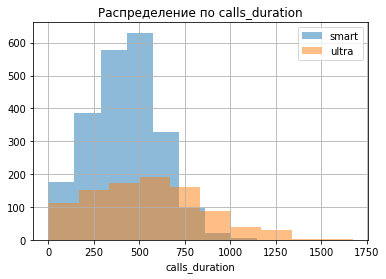

Тариф "Смарт":
Среднее значение = 419.06
Дисперсия = 35844.19
Стандартное отклонение = 189.33
-----------------------------------
Тариф "Ультра":
Среднее значение = 545.45
Дисперсия = 94203.42
Стандартное отклонение = 306.93
__________________________________________________


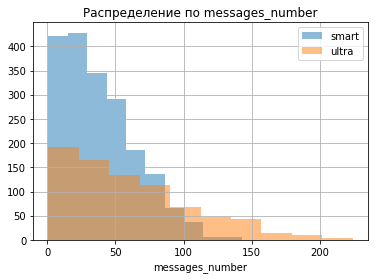

Тариф "Смарт":
Среднее значение = 38.72
Дисперсия = 717.59
Стандартное отклонение = 26.79
-----------------------------------
Тариф "Ультра":
Среднее значение = 61.16
Дисперсия = 2109.66
Стандартное отклонение = 45.93
__________________________________________________


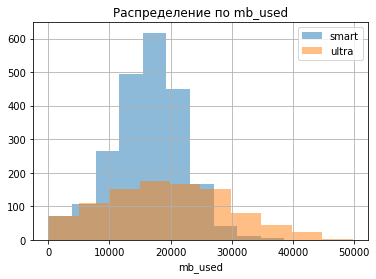

Тариф "Смарт":
Среднее значение = 16244.47
Дисперсия = 34469075.74
Стандартное отклонение = 5871.04
-----------------------------------
Тариф "Ультра":
Среднее значение = 19688.59
Дисперсия = 99058834.61
Стандартное отклонение = 9952.83
__________________________________________________


In [48]:
for column in ['calls_duration', 'messages_number', 'mb_used']:
        
        smart_calls_number_array = df[column].loc[df['tariff'] == 'smart']
        ultra_calls_number_array = df[column].loc[df['tariff'] == 'ultra']
                       
        mean_smart = np.mean(smart_calls_number_array).round(2)
        variance_estimate_smart = np.var(smart_calls_number_array, ddof=1).round(2)
        standard_deviation_smart = np.std(smart_calls_number_array,ddof=1).round(2)

        mean_ultra = np.mean(ultra_calls_number_array).round(2)
        variance_estimate_ultra = np.var(ultra_calls_number_array, ddof=1).round(2)
        standard_deviation_ultra = np.std(ultra_calls_number_array,ddof=1).round(2)
        
        smart_calls_number_array.hist(alpha = 0.5)
        ultra_calls_number_array.hist(alpha = 0.5)
        plt.title('Распределение по ' + column)
        plt.xlabel(column)
        plt.legend(['smart', 'ultra'])
        plt.show()
        
        print('Тариф "Смарт":')
        print('Среднее значение =', mean_smart)
        print('Дисперсия =', variance_estimate_smart)    
        print('Стандартное отклонение =', standard_deviation_smart) 
        
        print('-'*35)
        
        print('Тариф "Ультра":')
        print('Среднее значение =', mean_ultra)
        print('Дисперсия =', variance_estimate_ultra)    
        print('Стандартное отклонение =', standard_deviation_ultra) 
        
        print('_'*50)


Выводы:
- Дисперсия и среднеквадратическое отклонение по тарифу `Смарт` меньше, чем у пользователей с тарифом `Ультра` по всем показателям.
- Данные `mp_used` и `calls_duration` для тарифа `Смарт` скошены влево в то время, как для тарифа `Ультра` данные распределены более нормально.
- Данные для тарифов `Ультра` и `Смарт` - унимодальны. Тариф `Смарт` имеет более выраженную моду, чем тариф `Ультра`.

  
- Для тарифа `Смарт` пользователи в среднем разговаривают 419 минут, что полностью укладывает в пакет тарифа, в то время как пользователи тарифа `Ультра` используют только 1/6 часть от доступных звонков. На тарифе `Смарт` пользователи после 500 минут начинают экономить звонки, поэтому данные скошены влево. На тарифе `Ультра` пользователи намного свободнее, предположительно никто не экономит, и длительность звонков составляет столько, сколько необходимо, поэтому данные имеют более нормальное распределение.
- Количество отправляемых сообщений по тарифу `Смарт` - 39 шт., что также полностью покрывается тарифом. У тарифа `Ультра` этот показатель - 61шт., что очень мало в сравнении с доступными 1000 сообщений. Оба графика убывающие. Предположу, что сообщения уже мало кто использует для переписки и чаще используют их там, где нельзя заменить мессенджерами (например, подача показаний в ЖКХ, голосование по СМС и т.д.).
- На тарифе `Смарт` пользователи в среднем расходуют весь доступный интернет и вынуждены оплачивать его сверх тарифа, в то время, как на тарифе `Ультра` среднее значение составляет 2/3 от доступного. Однако потребление интернет-трафика примерно одинаковое (до 15-20Гб  - те самые 2/3 от тарифа Ультра), что говорит о том, что интернетом пользуются одинаково на обоих тарифах.
- Пользователи тарифа `Smart` расходуют доступные лимиты по количеству звонков и интернет-трафика, хотя есть и те, кто не звонят, не отправляют смс и не пользуются интернетом.
- Пользователи тарифа `Ultra` комфортно чувствуют себя в рамках тарифа, но и его стоимость соответствующая.

## Проверка гипотез

In [49]:
df

,user_id,month,calls_number,calls_duration,messages_number,mb_used,tariff,city,income
0,1000,5,22.0,159.0,22.0,2257.0,ultra,краснодар,1950
1,1000,6,43.0,172.0,60.0,23262.0,ultra,краснодар,1950
2,1000,7,47.0,340.0,75.0,14017.0,ultra,краснодар,1950
3,1000,8,52.0,408.0,81.0,14072.0,ultra,краснодар,1950
4,1000,9,58.0,466.0,57.0,14583.0,ultra,краснодар,1950
...,...,...,...,...,...,...,...,...,...
3209,1498,10,41.0,247.0,42.0,20614.0,smart,владикавказ,1750
3210,1499,9,9.0,70.0,11.0,1849.0,smart,пермь,550
3211,1499,10,68.0,449.0,48.0,17824.0,smart,пермь,1150
3212,1499,11,74.0,612.0,59.0,17994.0,smart,пермь,1513


## Проверка гипотезы №1 (средняя выручка пользователей тарифов «Ультра» и «Смарт» различается)

- Гипотеза H₀ — средний доход от пользователей с тарифом «Ультра» равен среднему доходу от пользователей с тарифом «Смарт».
- Гипотеза H₁ — средний доход от пользователей с тарифом «Ультра» не равен среднему доходу от пользователей с тарифом «Смарт».
- Критический уровень статистической значимости alpha = 1%, т.к. объем выборки у нас достаточно большой.

In [50]:
smart = df['income'].loc[df['tariff'] == 'smart']
ultra = df['income'].loc[df['tariff'] == 'ultra']

In [51]:
[np.var(x, ddof=1) for x in [smart, ultra]]

[675423.4435682568, 143491.24055961374]

Дисперсии неравны (разница в 4.7 раз), поэтому передаем параметр `equal_var = False`

In [52]:
from scipy import stats as st
import numpy as np

alpha = 0.01 # критический уровень статистической значимости
             # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    smart, 
    ultra, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.6398772066966188e-245
Отвергаем нулевую гипотезу


#### Вывод:  cредний доход от пользователей с тарифом `Ультра` не равен среднему доходу от пользователей с тарифом `Смарт`.

In [53]:
print('Медианная доходность тарифа "Ультра" =', df['income'].loc[df['tariff'] == 'ultra'].median().round(2))
print('Медианная доходность тарифа "Смарт" =', df['income'].loc[df['tariff'] == 'smart'].median().round(2))
print('Средняя доходность тарифа "Ультра" =', df['income'].loc[df['tariff'] == 'ultra'].mean().round(2))
print('Средняя доходность тарифа "Смарт" =', df['income'].loc[df['tariff'] == 'smart'].mean().round(2))

Медианная доходность тарифа "Ультра" = 1950.0
Медианная доходность тарифа "Смарт" = 1039.0
Средняя доходность тарифа "Ультра" = 2071.07
Средняя доходность тарифа "Смарт" = 1295.54


- Средняя доходность тарифы `Ультра` выше, чем у тарифа `Смарт`.
- Медианная доходность тарифа `Ультра` равна абонентской плате в то время, как у тарифа `Смарт` превышает абонентскую плату почти вдвое.

## Проверка гипотезы №2 (средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов)
- Гипотеза H₀ — средний доход с Москвы равен среднему доходу от других вместе взятых городов.
- Гипотеза H₁ — средний доход с Москвы не равен среднему доходу от других вместе взятых городов.
- Критический уровень статистической значимости alpha = 1%, т.к. объекм выборки у нас достаточно большой.

In [54]:
moscow = df['income'].loc[df['city'] == 'москва']
no_moscow = df['income'].loc[df['city'] != 'москва']

In [55]:
[np.var(x, ddof=1) for x in [moscow, no_moscow]]

[565263.5110944166, 657893.8831006498]

Дисперсии неравны (разница около 16%) - это много, поэтому передаем параметр `equal_var = False`

In [56]:
from scipy import stats as st
import numpy as np

alpha = .01 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    moscow, 
    no_moscow, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5117150826987625
Не получилось отвергнуть нулевую гипотезу


#### Вывод: хотя доходность Москвы и доходность от всех других городов (суммарно) неодинаковые, с вероятностью в почти 53% различие можно получить случайно.

In [57]:
df.groupby('city')['income'].mean().sort_values()

city
тамбов           596.478261
химки            638.400000
белгород         764.066667
новороссийск     834.961538
волжский         892.857143
                   ...     
брянск          2030.357143
оренбург        2059.153846
череповец       2131.214286
саранск         2183.772727
воронеж         2301.358974
Name: income, Length: 76, dtype: float64

In [58]:
print('Медианная доходность по Москве =', df['income'].loc[df['city'] == 'москва'].median().round(2))
print('Медианная доходность по всем городам (кроме Москвы) =', df['income'].loc[df['city'] != 'москва'].median().round(2))
print('Средняя доходность по Москве =', df['income'].loc[df['city'] == 'москва'].mean().round(2))
print('Средняя доходность по всем городам (кроме Москвы) =', df['income'].loc[df['city'] != 'москва'].mean().round(2))

Медианная доходность по Москве = 1750.0
Медианная доходность по всем городам (кроме Москвы) = 1587.0
Средняя доходность по Москве = 1551.46
Средняя доходность по всем городам (кроме Москвы) = 1528.93


## Общий вывод:


- Пользователей с тарифом `Смарт`, приблизительно, в три раза больше, чем `Ультра`.
- Есть пользователи, которые за месяц вообще не звонят, не пользуются интернетом или не отправляют СМС.
- Продолжительность вызовов, количество отправленных сообщений, количество интернет-трафика на тарифе `Смарт` каждый месяц больше (≈ в два раза), чем на тарифе `Ультра`.
- Медианная доходность тарифа `Ультра` равна абонентской плате в то время, как у тарифа `Смарт` превышает абонентскую плату почти вдвое (`"Скупой платит дважды"`).
- Средняя доходность тарифа `Ультра` выше, чем у тарифа `Смарт`.
- Средняя доходность Москвы и доходность от всех других городов (суммарно) приблизительно равны.